# 2k signals generation

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings

# ===============================
# 1. TERMINAL CONSTRUCTION
# ===============================

def prepare_terminals(df):
    """
    Transforms raw OHLCV + Taker data into stationary terminals.
    REQUIRED columns:
    Open, High, Low, Close, Volume,
    Taker buy base asset volume, Number of trades
    """

    df = df.copy()

    terminals = pd.DataFrame(index=df.index)

    # --- Target ---
    terminals["ret"] = np.log(df["Close"] / df["Close"].shift(1))

    # --- Microstructure signals ---
    terminals["taker_ratio"] = (
        df["Taker buy base asset volume"] / (df["Volume"] + 1e-6)
    )

    terminals["trade_intensity"] = (
        df["Number of trades"] / (df["Volume"] + 1e-6)
    )

    # --- Normalized price features ---
    terminals["open_norm"] = df["Open"] / df["Close"] - 1
    terminals["high_norm"] = df["High"] / df["Close"] - 1
    terminals["low_norm"] = df["Low"] / df["Close"] - 1

    # --- Volume Z-score ---
    vol_mean = df["Volume"].rolling(20).mean()
    vol_std = df["Volume"].rolling(20).std()
    terminals["volume_z"] = (df["Volume"] - vol_mean) / (vol_std + 1e-6)

    terminals = terminals.replace([np.inf, -np.inf], np.nan)
    terminals = terminals.dropna()

    return terminals


# ===============================
# 2. FAST ALPHA EVALUATOR
# ===============================

class FastAlphaEvaluator:
    def __init__(self, data):
        self.data = data
        self.arrays = {c: data[c].values for c in data.columns}

    def apply_op(self, a, b, op):
        if op == "add":
            return a + b
        if op == "sub":
            return a - b
        if op == "mul":
            return a * b
        if op == "div":
            return a / (b + 1e-6)
        raise ValueError(op)

    def ts_mean(self, x, n):
        return pd.Series(x).rolling(n).mean().values


# ===============================
# 3. SYNERGISTIC ALPHA MINER
# ===============================

def generate_synergistic_pool_fast(
    df,
    target="ret",
    pool_size=2000,
    min_ic=0.015,
    max_corr=0.70,
    max_attempts_factor=50,
):
    """
    Fast synergistic alpha miner.
    """

    if target not in df.columns:
        raise ValueError(
            f"Target '{target}' not found. "
            "Did you forget to run prepare_terminals()?"
        )

    evaluator = FastAlphaEvaluator(df)

    features = [c for c in df.columns if c != target]
    ops = ["add", "sub", "mul", "div"]
    windows = [5, 10, 20, 40]

    target_arr = df[target].values
    T = len(df)

    alpha_pool = []
    signal_bank = []

    MAX_ATTEMPTS = pool_size * max_attempts_factor

    warnings.filterwarnings("ignore", category=RuntimeWarning)

    pbar = tqdm(total=pool_size, desc="Mining alphas")
    attempts = 0

    while len(alpha_pool) < pool_size and attempts < MAX_ATTEMPTS:
        attempts += 1

        # --- Random formula sampling ---
        f1, f2 = np.random.choice(features, 2, replace=False)
        op = np.random.choice(ops)
        w = np.random.choice(windows)

        a = evaluator.arrays[f1]
        b = evaluator.arrays[f2]

        base = evaluator.apply_op(a, b, op)

        if np.nanstd(base) < 1e-6:
            continue

        signal = evaluator.ts_mean(base, w)

        if np.nanstd(signal) < 1e-6:
            continue

        # --- IC with NaN-safe masking ---
        mask = np.isfinite(signal) & np.isfinite(target_arr)
        if mask.sum() < 50:
            continue

        ic = np.corrcoef(signal[mask], target_arr[mask])[0, 1]

        if np.isnan(ic) or abs(ic) < min_ic:
            continue

        # --- Redundancy check ---
        if signal_bank:
            recent = np.vstack(signal_bank[-100:])
            corr_vec = np.abs(
                np.corrcoef(recent, signal)[-1, :-1]
            )
            if corr_vec.max() > max_corr:
                continue

        # --- Accept alpha ---
        alpha_pool.append(
            {
                "id": f"alpha_{len(alpha_pool)}",
                "formula": f"{f1} {f2} {op} ts_mean({w})",
                "ic": ic,
            }
        )

        signal_bank.append(signal)
        pbar.update(1)

    pbar.close()

    print(
        f"Finished: {len(alpha_pool)} alphas "
        f"from {attempts} attempts"
    )

    return alpha_pool, np.vstack(signal_bank)


# ===============================
# 4. MAIN ENTRY POINT
# ===============================

if __name__ == "__main__":

    # ---- Load raw data ----
    raw_df = pd.read_csv("original_data.csv")

    # ---- Build terminals ----
    terminals_df = prepare_terminals(raw_df)

    # ---- Mine alpha pool ----
    alpha_pool, signal_matrix = generate_synergistic_pool_fast(
        terminals_df,
        target="ret",
        pool_size=2000,
    )

    # ---- Save results ----
    alpha_df = pd.DataFrame(alpha_pool)
    alpha_df.to_csv("alpha_pool_200000.csv", index=False)

    np.save("alpha_signals.npy", signal_matrix)

    print("Alpha mining complete.")



In [ ]:
alpha_df = pd.DataFrame(alpha_pool)

# Sanity check
assert "id" in alpha_df.columns, "alpha_pool must contain 'id' field"

# Save metadata
alpha_df.to_csv("alpha_pool.csv", index=False)

In [ ]:
num_alphas, T = signal_matrix.shape

# Build DataFrame: time × alpha
signal_df = pd.DataFrame(
    signal_matrix.T,                 # transpose to (T, num_alphas)
    columns=alpha_df["id"].values,   # alpha names
    index=terminals_df.index[:T]     # time index alignment
)

# Optional: inspect
print(signal_df.head())

----

# 20k signals generation with bigger complexity

## running and executor

In [ ]:
# stage1_features.py
import numpy as np
import pandas as pd


def zscore(x, w):
    m = pd.Series(x).rolling(w).mean()
    s = pd.Series(x).rolling(w).std()
    return ((x - m) / s).values


def signed_sqrt(x):
    return np.sign(x) * np.sqrt(np.abs(x))


def build_base_features(df):
    eps = 1e-9

    close = df["Close"].values
    open_ = df["Open"].values
    high = df["High"].values
    low = df["Low"].values
    volume = df["Volume"].values
    trades = df["Number of trades"].values
    taker_buy = df["Taker buy base asset volume"].values
    quote_vol = df["Quote asset volume"].values

    features = {
        "ret": np.diff(np.log(close), prepend=np.nan),
        "range": (high - low) / (close + eps),
        "body": (close - open_) / (high - low + eps),
        "price_loc": (close - low) / (high - low + eps),
        "vol_z": (volume - volume.mean()) / (volume.std() + eps),
        "trade_intensity": trades / (volume + eps),
        "taker_ratio": taker_buy / (volume + eps),
        "quote_pressure": quote_vol / (volume + eps),
        "vwap_dev": (close - quote_vol / (volume + eps)) / close,
    }

    return features


def stage1_generate(df, windows=(3, 5, 10, 20, 30, 60)):
    base = build_base_features(df)

    signals = []
    formulas = []

    for name, x in base.items():
        for w in windows:
            roll_mean = pd.Series(x).rolling(w).mean().values
            roll_std = pd.Series(x).rolling(w).std().values

            candidates = {
                f"{name}_mean_{w}": roll_mean,
                f"{name}_std_{w}": roll_std,
                f"{name}_z_{w}": zscore(x, w),
                f"{name}_delta_{w}": x - pd.Series(x).shift(w).values,
                f"{name}_rank_{w}": pd.Series(x).rolling(w).rank().values / w,
                f"{name}_sqrt_{w}": signed_sqrt(roll_mean),
            }

            for k, v in candidates.items():
                signals.append(v)
                formulas.append(k)

    return signals, formulas

# stage2_composition.py
import numpy as np
from itertools import combinations


def safe_div(a, b):
    out = np.full_like(a, np.nan, dtype=float)
    mask = np.isfinite(a) & np.isfinite(b) & (np.abs(b) > 1e-6)
    out[mask] = a[mask] / b[mask]
    return out


def safe_mul(a, b, cap=1e6):
    out = a * b
    return np.clip(out, -cap, cap)


def stage2_compose(signals, formulas, max_pairs=20000):
    new_signals = []
    new_formulas = []

    pairs = list(combinations(range(len(signals)), 2))[:max_pairs]

    for i, j in pairs:
        a, b = signals[i], signals[j]

        new_signals.append(a + b)
        new_formulas.append(f"({formulas[i]}+{formulas[j]})")

        new_signals.append(a - b)
        new_formulas.append(f"({formulas[i]}-{formulas[j]})")

        new_signals.append(safe_mul(a, b))
        new_formulas.append(f"({formulas[i]}*{formulas[j]})")

        new_signals.append(safe_div(a, b))
        new_formulas.append(f"({formulas[i]}/{formulas[j]})")

    return new_signals, new_formulas

# stage3_screening.py
import numpy as np


def screen_alphas(
    signals,
    formulas,
    target,
    eval_len=1000,
    min_ic=0.01,
    max_corr=0.7,
    max_keep=30000,
):
    kept_signals = []
    kept_meta = []

    t = target[:eval_len]

    for s, f in zip(signals, formulas):
        s_eval = s[:eval_len]

        mask = np.isfinite(s_eval) & np.isfinite(t)
        if mask.sum() < 50:
            continue

        ic = np.corrcoef(s_eval[mask], t[mask])[0, 1]
        if np.isnan(ic) or abs(ic) < min_ic:
            continue

        if kept_signals:
            recent = np.vstack([x[:eval_len] for x in kept_signals[-200:]])
            corr = np.abs(np.corrcoef(recent, s_eval)[-1, :-1]).max()
            if corr > max_corr:
                continue

        kept_signals.append(s)
        kept_meta.append({"formula": f, "ic": ic})

        if len(kept_signals) >= max_keep:
            break

    return kept_meta, np.vstack(kept_signals)

# apg_execution.py
import pandas as pd
import numpy as np

# finally fucking execution boy!!!!
df = pd.read_csv('original_data.csv')
def main():
    df = pd.read_csv('original_data.csv')

    print("Stage 1: feature generation")
    s1_signals, s1_formulas = stage1_generate(df)
    print("Primary signals:", len(s1_signals))

    print("Stage 2: composition")
    s2_signals, s2_formulas = stage2_compose(
        s1_signals, s1_formulas, max_pairs=20000
    )
    print("Raw composed alphas:", len(s2_signals))

    all_signals = s1_signals + s2_signals
    all_formulas = s1_formulas + s2_formulas

    target = np.diff(np.log(df["Close"].values), prepend=np.nan)

    print("Stage 3: screening")
    meta, signal_matrix = screen_alphas(
        all_signals,
        all_formulas,
        target,
    )

    pd.DataFrame(meta).to_csv("alpha_pool.csv", index=False)
    np.save("alpha_signals.npy", signal_matrix)

    print("Final alphas:", len(meta))


if __name__ == "__main__":
    main()


# gemini's code

<Axes: >

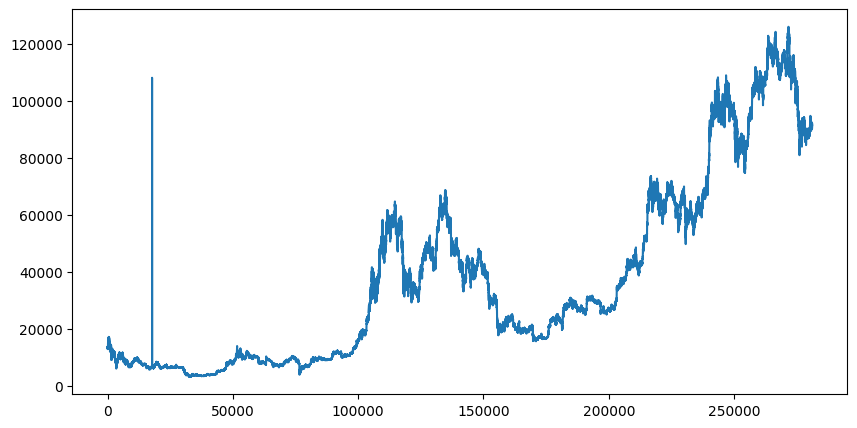

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('original_data.csv')
df['Close'].plot(figsize=(10, 5))

In [9]:
df=pd.read_csv('mega_alpha_pool.csv')
df['ic'].mean()

np.float64(-0.06732384977045199)